# Solución Ejercicio 2 Examen - Clasificación Imágenes CIFAR10


-   **Autores:** Mauricio Beltrán, Juan Antonio Vicente, Alfonso
    Carabantes
-   **Fecha:** Octubre 2020

------------------------------------------------------------------------

# Introducción

Para la resolución de este ejercicio usaremos la Base de datos obtenida


Usaremos durante el entrenamiento los datos de entrenamiento y
validación y luego finalmente para ese modelo **evaluaremos** el modelo
con los datos de test.

Durante el ejercicio, vamos a intentar usar diferentes técnicas para ver
si podemos conseguir mejorar los resultados de precisión de nuestro
entrenamiento.

Plantearemos diferentes modelos con complejidades y configuraciones
diferentes en cuanto a la arquitectura, y también veremos como usar el
**Data Augmentation**, en este caso generando los nuevos gráficos de
forma estática en lugar de online mientras se ejecuta el entrenamiento.
Otro de las técnicas que usaremos será el trabajo con una red
**preentrenada**, configurando un **Feature Extraction** y **Fine
Tuning**.

Para la resolución del ejercicio hemos construido una serie de
**funciones** que nos permitirán tener un código más limpio,
reutilizable y que sea más fácil seguir el flujo del trabajo. Estas
funciones están en un fichero aparte (aunque se mostrarán al final de la
documentación del ejercicio).



# Información de versiones e Importación de funciones propias

In [46]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

import tensorflow as tf
print(tf.__version__)

Python version
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
2.8.2


Importamos todos los módulos que vamos a usar así como las funciones que hemos creado.

In [47]:
import os
import sys
import tensorflow as tf
import sys
import pathlib
import tarfile
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
import random
import zipfile


def carga_dataset():
  global train_images
  global train_labels
  global test_images
  global test_labels
  (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
  # Normalizamos los datos entre 0 y 1
  train_images, test_images = train_images / 255.0, test_images / 255.0
  train_images = train_images.reshape(train_images.shape[0], 32, 32, 3)
  test_images = test_images.reshape(test_images.shape[0], 32, 32, 3)

  
def crea_generadores_imagenes():
  global training_image_flow
  global validation_image_flow
  global test_image_flow
  global training_generator
  global validation_generator
  global test_generator

  training_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
  
  test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

  training_image_flow = training_generator.flow(
    train_images,
    train_labels,
    batch_size=32)
  
  test_image_flow = test_generator.flow(
    test_images,
    test_labels,
    batch_size = 32,
    shuffle = False)

  
def visualiza_imagenes_random():
  class_names = ['avion', 'coche', 'pajaro', 'gato', 'ciervo',
               'perro', 'rana', 'caballo', 'barco', 'camion']

  plt.figure(figsize=(10,10))
  for i in range(25):
    n = random.randint(1, 500)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[n], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[n][0]])
  plt.show()





def crea_modelo_1():
  modelo = tf.keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))

  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_2():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_3():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.BatchNormalization())
  modelo.add(tf.keras.layers.Dropout(.2))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def crea_modelo_4():
  modelo = keras.Sequential()
  modelo.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
  modelo.add(keras.layers.MaxPooling2D(2))
  modelo.add(keras.layers.Flatten())
  modelo.add(keras.layers.Dense(512, activation='relu'))
  modelo.add(keras.layers.Dense(10, activation='softmax'))
  modelo.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
  return modelo

def entrena_modelo(modelo):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    train_images,
    train_labels,
    epochs = 10,
    validation_data = (test_images,test_labels),
    batch_size = 64 )
  return history

def entrena_modelo_augmentation(modelo):
  # Ejecutamos el entrenamiento
  # guardando el histórico de la
  # función de pérdida y la métrica
  history = modelo.fit(
    training_image_flow,
    epochs = 10,
    validation_data = (test_images,test_labels),
    batch_size = 64 )
  return history

               
def muestra_historico_entrenamiento(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(10)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

def guarda_modelo(modelo, nombre_modelo):
  modelo.save(nombre_modelo, save_format = "h5")

def carga_modelo(nombre_modelo):
  modelo = tf.keras.models.load_model(nombre_modelo)
  return modelo

def evalua_modelo(modelo):
  evalua = modelo.evaluate(test_images,test_labels)
  return evalua

def funcion1():
    return 1


# Descarga de las imágenes

Vamos automatizar la descarga de las imágenes que vamos a usar.

In [48]:
carga_dataset()

# Visualización de Imágenes

Vamos a mostrar varias imágenes de entrenamiento.

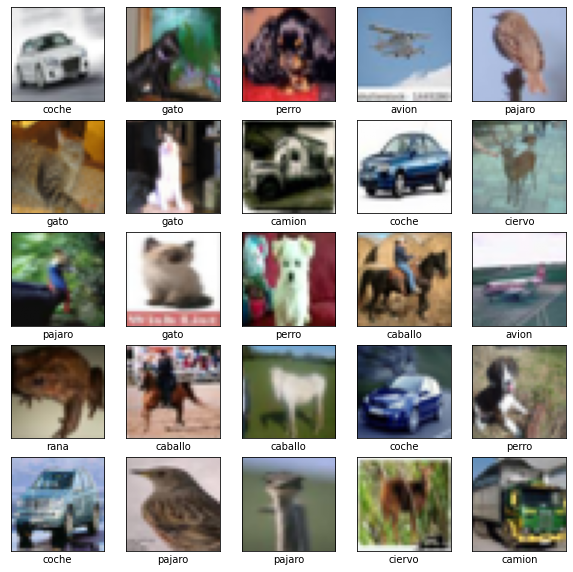

In [49]:
visualiza_imagenes_random()

Vamos a pasar a ver los diferentes modelos que vamos a probar.

# Modelo 1 ( 32,64, adam)

En este modelo vamos a tener:

-   Capa **convolución** con 32 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 10 neuronas y activación **softmax** que nos da
    la clasificación

## Creamos el modelo


In [50]:
modelo_1 = crea_modelo_1()
modelo_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 512)              

## Entrenamos el modelo

In [51]:

history_1 = entrena_modelo(modelo_1)

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 1.3359 - accuracy: 0.5261 - val_loss: 1.1103 - val_accuracy: 0.6067
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.9705 - accuracy: 0.6583 - val_loss: 0.9499 - val_accuracy: 0.6614
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.8108 - accuracy: 0.7165 - val_loss: 0.9399 - val_accuracy: 0.6735
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6757 - accuracy: 0.7655 - val_loss: 0.8198 - val_accuracy: 0.7186
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5464 - accuracy: 0.8110 - val_loss: 0.8737 - val_accuracy: 0.7131
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4192 - accuracy: 0.8558 - val_loss: 0.9056 - val_accuracy: 0.7176
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2969 - accuracy: 0.8999 - val_loss: 0.9975 - val_accuracy: 0.7064
Epoch 

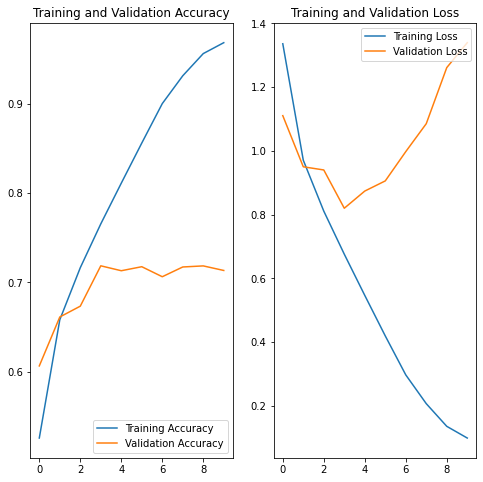

In [52]:
muestra_historico_entrenamiento(history_1)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [53]:
guarda_modelo(modelo_1,"modelo_1_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [54]:
modelo_1 = carga_modelo("modelo_1_cifar10")
evalua_1 = evalua_modelo(modelo_1)
print(evalua_1)

313/313 [==============================] - 1s 3ms/step - loss: 1.3393 - accuracy: 0.7134
[1.3392995595932007, 0.7134000062942505]


# Modelo 2 ( 64,128, 128 adam)

Ampliamos el modelo con una capa de convolución y pooling más y mayor
número de filtros

En este modelo vamos a tener:

-   Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu**
-   Capa de **pooling** tipo maxpooling de tamaño 2x2
-   Capa para **aplanar** la información
-   Capa **dénsamente** conectada de 512 neuronas y activación **relu**
-   Capa de **salida** de 1 neurona y activación **sigmoid** que nos da
    la clasificación
-   Optimizador **adam**

## Creamos el modelo

In [55]:
modelo_2 = crea_modelo_2()
modelo_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 128)       

## Entrenamos el modelo

In [56]:
history_2 = entrena_modelo(modelo_2)

Epoch 1/10
782/782 [==============================] - 6s 7ms/step - loss: 1.3757 - accuracy: 0.5042 - val_loss: 1.0418 - val_accuracy: 0.6345
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.9397 - accuracy: 0.6714 - val_loss: 0.9126 - val_accuracy: 0.6837
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.7609 - accuracy: 0.7351 - val_loss: 0.8249 - val_accuracy: 0.7115
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6302 - accuracy: 0.7795 - val_loss: 0.8152 - val_accuracy: 0.7264
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5179 - accuracy: 0.8184 - val_loss: 0.7654 - val_accuracy: 0.7448
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4172 - accuracy: 0.8528 - val_loss: 0.7746 - val_accuracy: 0.7445
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3204 - accuracy: 0.8876 - val_loss: 0.8583 - val_accuracy: 0.7539
Epoch 

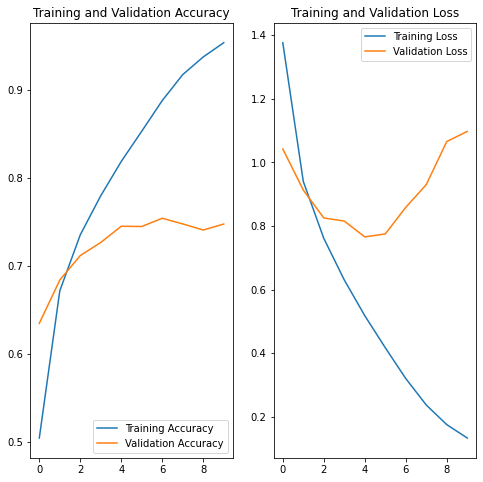

In [57]:
muestra_historico_entrenamiento(history_2)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [58]:
guarda_modelo( modelo_2, "modelo_2_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [59]:
modelo_2 = carga_modelo("modelo_2_cifar10")
evalua_2 = evalua_modelo(modelo_2)
print(evalua_2)

313/313 [==============================] - 1s 3ms/step - loss: 1.0969 - accuracy: 0.7473
[1.0969083309173584, 0.7473000288009644]


# Modelo 3 ( 64,128, 128 adam Dropout BatchNormalization)

Vamos a construir ahora un modelo más complejo en el que vamos a añadir
más filtros, así como regularización mediante dropout para conseguir
mejor generalización.

En este modelo vamos a tener: 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipo maxpooling de tamaño 2x2 
- Capa **convolución** con 64 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** - Capa de **pooling** tipo maxpooling de tamaño
2x2 
- Capa **convolución** con 128 filtros, tamaño 3x3 y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **pooling** tipomaxpooling de tamaño 2x2 
- Capa para **aplanar** la información 
- Capa **dénsamente** conectada de 512 neuronas y activación **relu** 
- Capa de **batchnormalization** 
- Capa de **dropout** quitando el 25% de las neuronas. 
- Capa de **salida** de 1 neurona y activación **sigmoid** que nos da la clasificación

## Creamos el modelo

In [60]:
modelo_3 = crea_modelo_3()
modelo_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

## Entrenamos el modelo

In [61]:
history_3 = entrena_modelo(modelo_3)

Epoch 1/10
782/782 [==============================] - 7s 8ms/step - loss: 1.2401 - accuracy: 0.5800 - val_loss: 1.1981 - val_accuracy: 0.5993
Epoch 2/10
782/782 [==============================] - 6s 7ms/step - loss: 0.8108 - accuracy: 0.7164 - val_loss: 1.1942 - val_accuracy: 0.6059
Epoch 3/10
782/782 [==============================] - 6s 7ms/step - loss: 0.6575 - accuracy: 0.7713 - val_loss: 1.1909 - val_accuracy: 0.6265
Epoch 4/10
782/782 [==============================] - 6s 7ms/step - loss: 0.5422 - accuracy: 0.8104 - val_loss: 0.9143 - val_accuracy: 0.6928
Epoch 5/10
782/782 [==============================] - 6s 7ms/step - loss: 0.4469 - accuracy: 0.8422 - val_loss: 0.9884 - val_accuracy: 0.7007
Epoch 6/10
782/782 [==============================] - 6s 7ms/step - loss: 0.3627 - accuracy: 0.8713 - val_loss: 0.7511 - val_accuracy: 0.7576
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.2838 - accuracy: 0.8998 - val_loss: 0.7695 - val_accuracy: 0.7652
Epoch 

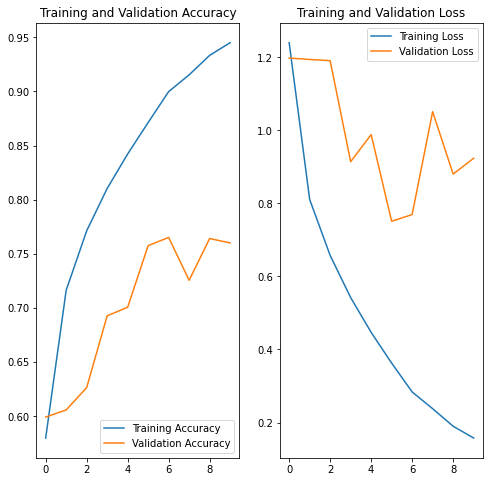

In [62]:
muestra_historico_entrenamiento(history_3)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [63]:
guarda_modelo(modelo_3,"modelo_3_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [64]:
modelo_3 = carga_modelo("modelo_3_cifar10")
evalua_3 = evalua_modelo(modelo_3)
print(evalua_3)


313/313 [==============================] - 1s 3ms/step - loss: 0.9236 - accuracy: 0.7601
[0.9236047863960266, 0.7601000070571899]


# Modelo 4 ( 64,128, 128 adam  Augmentation)

Vamos a aplicar la técnica del **Data Augmentation** a nuestro conjuto
de imágenes. De esta manera, con las transformaciones a las imágenes conseguiremos imágenes "nuevas" para poder tener más imágenes para entrenar nuestro modelo y poder conseguir que generalice mejor (no haya tanto sobreajuste).
En cuanto la arquitectura seguiremos manteniendo la misma que teníamos.

## Creamos el modelo

In [65]:
modelo_4 = crea_modelo_4()
modelo_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 128)       

## Entrenamos el modelo

Usamos el data augmentation para generar las nuevas imágenes durante el entrenamiento.

In [66]:


history_4 = entrena_modelo_augmentation(modelo_4)


Epoch 1/10
1563/1563 [==============================] - 28s 17ms/step - loss: 1.6242 - accuracy: 0.0979 - val_loss: 1.3300 - val_accuracy: 0.0555
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2807 - accuracy: 0.0967 - val_loss: 1.0359 - val_accuracy: 0.1157
Epoch 3/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1397 - accuracy: 0.0977 - val_loss: 0.9827 - val_accuracy: 0.0987
Epoch 4/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0493 - accuracy: 0.0997 - val_loss: 0.9382 - val_accuracy: 0.1144
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9745 - accuracy: 0.0993 - val_loss: 0.9176 - val_accuracy: 0.0947
Epoch 6/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.9306 - accuracy: 0.1019 - val_loss: 0.9083 - val_accuracy: 0.1028
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8961 - accuracy: 0.1015 - val_loss: 0.7961 -

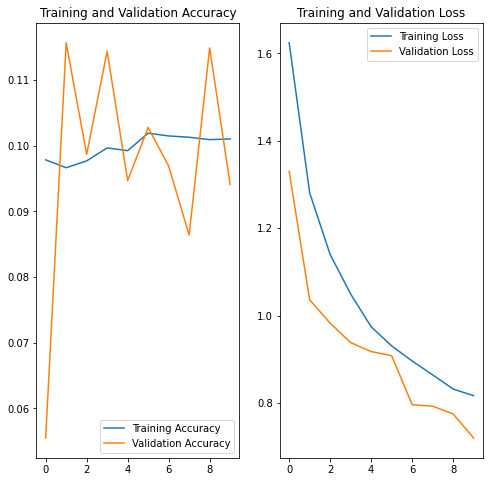

In [67]:
muestra_historico_entrenamiento(history_4)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [68]:
guarda_modelo(modelo_4,"modelo_4_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [69]:
modelo_4 = carga_modelo("modelo_4_cifar10")
evalua_4 = evalua_modelo(modelo_4)
print(evalua_4)

313/313 [==============================] - 1s 3ms/step - loss: 0.7199 - accuracy: 0.0941
[0.71988844871521, 0.0940999984741211]


# Modelo 5 Uso de Red Preentrenado Feature Extraction

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**. Usaremos la técnica de
**Extracción de features** que nos permite quitar de la red
convolucional la parte final del clasificador y poner la nuestra para la
clasificación binaria que queremos hacer. Hay que tener en cuenta que
esta red neuronal está pre-entrenada sobre más de 1 millón de imágenes
(ttp://www.image-net.org) y categoriza en 1.000 categorías.


La extracción de características consiste en utilizar las
representaciones aprendidas por una red anterior para extraer
características interesantes de nuevas muestras.

Estas características se ejecutan a través de un nuevo clasificador, que
se entrena desde cero.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [70]:
# Modelo base
modelo_base_vgg16 = tf.keras.applications.VGG16( weights='imagenet', input_shape=(32, 32, 3),include_top=False)

Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de
**VGG16**.

In [71]:
modelo_base_vgg16.trainable = False

modelo_5 = keras.Sequential()
modelo_5.add(modelo_base_vgg16)
modelo_5.add(keras.layers.Flatten())
modelo_5.add(keras.layers.Dense(256, activation='relu'))
modelo_5.add(keras.layers.Dense(10, activation='softmax'))
modelo_5.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


## Entrenamos el modelo

In [72]:
history_5 = entrena_modelo(modelo_5)

Epoch 1/10
782/782 [==============================] - 13s 16ms/step - loss: 1.3647 - accuracy: 0.5241 - val_loss: 1.2680 - val_accuracy: 0.5591
Epoch 2/10
782/782 [==============================] - 13s 17ms/step - loss: 1.1834 - accuracy: 0.5866 - val_loss: 1.1912 - val_accuracy: 0.5849
Epoch 3/10
782/782 [==============================] - 12s 16ms/step - loss: 1.1228 - accuracy: 0.6077 - val_loss: 1.1463 - val_accuracy: 0.5954
Epoch 4/10
782/782 [==============================] - 13s 17ms/step - loss: 1.0783 - accuracy: 0.6237 - val_loss: 1.1431 - val_accuracy: 0.5968
Epoch 5/10
782/782 [==============================] - 12s 16ms/step - loss: 1.0395 - accuracy: 0.6379 - val_loss: 1.1426 - val_accuracy: 0.5986
Epoch 6/10
782/782 [==============================] - 12s 16ms/step - loss: 1.0053 - accuracy: 0.6476 - val_loss: 1.1263 - val_accuracy: 0.6062
Epoch 7/10
782/782 [==============================] - 12s 16ms/step - loss: 0.9734 - accuracy: 0.6592 - val_loss: 1.1003 - val_accuracy:

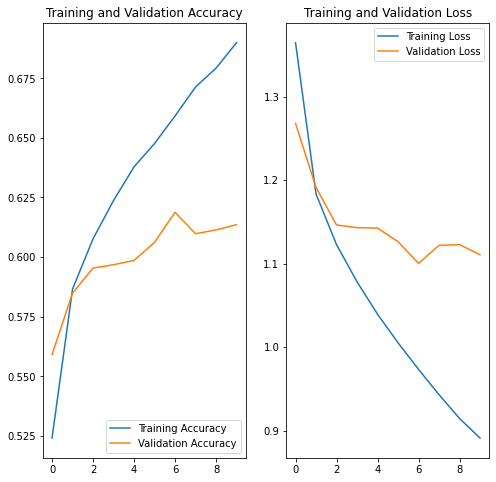

In [73]:
muestra_historico_entrenamiento(history_5)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [74]:
guarda_modelo(modelo_5,"modelo_5_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [75]:
modelo_5 = carga_modelo("modelo_5_cifar10")
evalua_5 = evalua_modelo(modelo_5)
print(evalua_5)

313/313 [==============================] - 4s 10ms/step - loss: 1.1107 - accuracy: 0.6136
[1.1107211112976074, 0.6136000156402588]


# Modelo 6 Uso de Red Preentrenado Fine Tunning

Vamos a usar una red **Pre-Entrenada** para implementar el clasificador,
en este caso usaremos la red **VGG16**). Usaremos la técnica de **Fine
Tunning** que nos permite por un lado entrenar las últimas capas de
convolución con nuestras imágenes de entrenamiento y por otro poner la
parte final del clasificador con las capas densamente conectadas, y así
poder obtener una mejor aproximación con nuestras imágenes. Hay que
tener en cuenta que esta red neuronal está pre-entrenada sobre más de 1
millón de imágenes (ttp://www.image-net.org) y categoriza en 1.000
categorías.

Vamos a instanciar una red preentrenada **VGG16** que es una de las
redes que vienen incluidas en Keras.


In [76]:
# Modelo base
modelo_base_vgg16_ft = tf.keras.applications.VGG16( weights='imagenet', input_shape=(32, 32, 3),include_top=False)

Construimos el modelo añadiendo la capa de clasificación que nosotros
necesitamos, además de **congelar (no entrenable)** los parámetros ya entrenados de **VGG16** hasta el bloque llamado **block5_conv3**.

In [77]:
#modelo_base_vgg16.trainable = False
modelo_base_vgg16_ft.trainable = True

set_trainable = False
for layer in modelo_base_vgg16_ft.layers:
# A partir de esta capa ya se convierte en entrable 
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

modelo_6 = keras.Sequential()
modelo_6.add(modelo_base_vgg16_ft)
modelo_6.add(keras.layers.Flatten())
modelo_6.add(keras.layers.Dense(256, activation='relu'))
modelo_6.add(keras.layers.Dense(10, activation='softmax'))
modelo_6.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])
modelo_6.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dense_21 (Dense)            (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 7,213,322
Non-trainable params: 7,635,264
_________________________________________________________________


## Entrenamos el modelo

In [84]:
history_6 = entrena_modelo(modelo_6)

Epoch 1/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0626 - accuracy: 0.9803 - val_loss: 1.7664 - val_accuracy: 0.7430
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0674 - accuracy: 0.9787 - val_loss: 1.7525 - val_accuracy: 0.7469
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0615 - accuracy: 0.9813 - val_loss: 1.7969 - val_accuracy: 0.7378
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0600 - accuracy: 0.9810 - val_loss: 1.8606 - val_accuracy: 0.7438
Epoch 5/10
782/782 [==============================] - 17s 22ms/step - loss: 0.0598 - accuracy: 0.9820 - val_loss: 1.9723 - val_accuracy: 0.7380
Epoch 6/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0625 - accuracy: 0.9812 - val_loss: 1.8548 - val_accuracy: 0.7477
Epoch 7/10
782/782 [==============================] - 18s 23ms/step - loss: 0.0495 - accuracy: 0.9852 - val_loss: 1.8597 - val_accuracy:

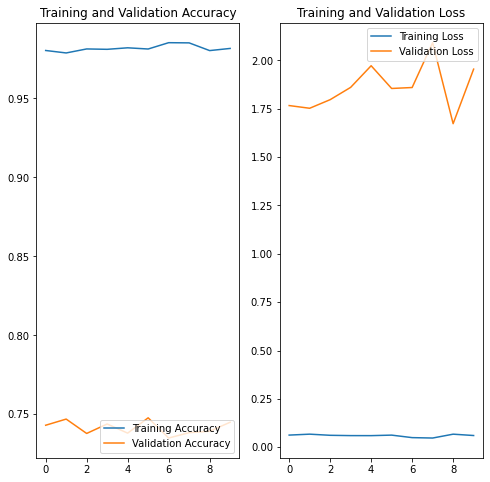

In [85]:
muestra_historico_entrenamiento(history_6)

Guardaremos el modelo para usarlo cuando lo necesitamos

In [86]:
guarda_modelo(modelo_6,"modelo_6_cifar10")

## Evaluamos el modelo con los datos de test

Vamos a evaluar los datos de test a ver que resultados nos dan, cargando
primero el modelo que queramos usar.

In [87]:
#modelo_6 = carga_modelo("modelo_6_cifar10")
evalua_6 = evalua_modelo(modelo_6)
print(evalua_6)

313/313 [==============================] - 3s 10ms/step - loss: 1.9547 - accuracy: 0.7449
[1.9547367095947266, 0.7448999881744385]


# Conclusiones

Hemos podido ir viendo con los diferentes modelos desde el más simple al
más complejo, pasando por el uso del Data Augmentation o usando redes
preentrenadas, que hemos conseguido ir mejorando en nuestros resultados
en el **accuracy** en los valores de test.

Parece claro que el mejor resultado lo hemos alcanzado con el uso del
**Fine tuning**.

Con esta primera aproximación podríamos intentar afinar más resultados
probando con diferentes **optimizadores** y sus parámetros, con usar un
mayor número de **épocas** de entrenamiento o incluso usar otras
**funciones de activación**.